<a href="https://colab.research.google.com/github/LANZhengyang/MFML_Bayesian_KNN/blob/master/MFML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from functools import reduce

In [0]:
iris = datasets.load_iris()
X = iris.data
y = iris.target


In [0]:
D=np.delete(X, -1, axis=0)

In [0]:
all_error = []
for k in range(2,50):
  sum=0
  for i in range(len(y)):
    Train_x=np.delete(X, i, axis=0)
    Train_y=np.delete(y, i, axis=0)
    neigh = neighbors.KNeighborsClassifier(n_neighbors=k)
    neigh.fit(Train_x, Train_y)
    if neigh.predict(X[i][np.newaxis, :]) != y[i]:
      sum=sum+1
  sum = sum/ len(y)  
  all_error.append(sum)
 # print("k= %d error rate= %.3f "%(k,sum) )

<BarContainer object of 48 artists>

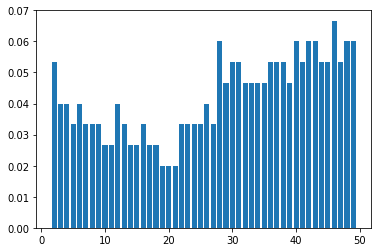

In [0]:
plt.bar(range(2,50),all_error)

In [0]:
import numpy as np
import matplotlib.pyplot as plt
class knn():
    def fit(self,X,y,n):
        self.X = X
        self.y=y
        self.n=n

    def distance(self,x_1,x_2):        
        return np.linalg.norm(x_1-x_2,ord=self.X.shape[1])   

    def get_neighbours(self,x):        
        all_distance = []
        for i in range(self.y.shape[0]):
            all_distance.append(self.distance(x,self.X[i]))       
        return np.argsort(all_distance)[:self.n]

    def potential_function(self,x,y_i):
      neighbors=self.get_neighbours(x)

      return np.sum(y[neighbors] == y_i)

    def mutual_neighbours(self,index,y_i):

      classifier = knn()
      Train_x=np.delete(self.X, index, axis=0)
      Train_y=np.delete(self.y, index, axis=0)
      classifier.fit(Train_x,Train_y,self.n)
      neighbors_index = classifier.get_neighbours(self.X[index])
      number_mutual_neighbours=0
      for i in range(self.n):
        Train_x_temp = self.X
        Train_y_temp = self.y
        Train_x_temp=np.delete(Train_x_temp, neighbors_index[i], axis=0)
        Train_y_temp=np.delete(Train_y_temp, neighbors_index[i], axis=0)
        classifier_temp = knn()
        classifier_temp.fit(Train_x_temp,Train_y_temp,self.n)
        if self.X[index] in Train_x_temp[classifier_temp.get_neighbours(self.X[neighbors_index[i]])]:
          if y_i == y[neighbors_index[i]] :       
            number_mutual_neighbours+=1
      return number_mutual_neighbours

#formula 1, when get = conditional
def distribution(index,beta,X,y,k,get="joint",y_i=0):
  classifier = knn()
  Train_x=np.delete(X, index, axis=0)
  Train_y=np.delete(y, index, axis=0)
  classifier.fit(Train_x,Train_y,k)
  all_dis=[]
  for j in range(3):
    pr_y_i_up = np.exp(beta*classifier.potential_function(X[index],j)/k)
    pr_y_i_down=0
    for i in range(3):
      pr_y_i_down = pr_y_i_down + (np.exp(beta*classifier.potential_function(X[index],i)/k))
    all_dis.append(pr_y_i_up/pr_y_i_down)
  z = np.sum(all_dis)
  if get=="joint":
    return all_dis/z
  elif get =="conditional":
    return all_dis[y_i]/z

#formula 2
def combined_predictors(X_given,beta,k,X,y,y_given):
  predict_list=[]
  Train_x=np.delete(X, X_given, axis=0)
  Train_y=np.delete(y, X_given, axis=0)
  predict_list=[]
  for i in range(len(X_given)):
    predict_list.append(distribution(index=X_given[i],beta=beta,X=X,y=y,k=k,get="conditional",y_i=y_given[i]))
  return reduce(lambda x,y:x * y,predict_list)

#formula 4
def distribution_Boltzmann(index,beta,X,y,k,get="conditional",y_i=0):

  classifier = knn()
  classifier.fit(X,y,k)
  classifier_temp = knn()
  Train_x=np.delete(X, index, axis=0)
  Train_y=np.delete(y, index, axis=0)
  classifier_temp.fit(Train_x,Train_y,k)
  all_dis=[]
  neighbors_index = classifier_temp.get_neighbours(X[index])
  for j in range(3):
    pr_y_i_left = classifier_temp.potential_function(X[index],j)
    pr_y_i_right= classifier.mutual_neighbours(index,y_i=y[index])
  #  print(pr_y_i_right)
    all_dis.append(np.exp((beta/k)*(pr_y_i_left+pr_y_i_right)))
  z = np.sum(all_dis) 
 # print(z)
  if get=="joint":

    return all_dis/z
  elif get =="conditional":
    return all_dis[y_i]/z


def Z(beta,k,X,y):
  s=0
  for i in range(len(y)):
    Train_x_temp = X
    Train_y_temp = y
    Train_x_temp=np.delete(X, i, axis=0)
    Train_y_temp=np.delete(y, i, axis=0)
    classifier_temp = knn()
    classifier_temp.fit(Train_x_temp,Train_y_temp,k)    
    s+= classifier_temp.potential_function(X[i],y[i]) /k



In [0]:
def get_S(X=X,y=y,k=40):
    s = 0
    for j in range(len(y)):
        Train_x = np.delete(X, j, axis=0)
        Train_y = np.delete(y, j, axis=0)
        classifier_neighbours = knn()
        classifier_neighbours.fit(Train_x,Train_y,k)
        for i in range(k):
            s += classifier.potential_function(X[j], y[j])
    return s/k

In [0]:
get_S(X=X[:90],y=y[:90],k=30)

In [197]:
distribution_Boltzmann(index=106,beta=2,X=X,y=y,k=10,get="joint",y_i=2)

array([0.12090363, 0.73142434, 0.14767203])

In [0]:
para=[0,0]
proba_max=0
for beta in range(6,12):
  for k in range(18,23):
    proba=1    
    for n in range(len(y)):
      proba=proba*distribution(index=n,beta=beta,X=X,y=y,k=k,get="conditional",y_i=y[n])
    print("proba(likelihood)=",proba,"beta=",beta,"k=",k)
    if proba>proba_max:
      proba_max = proba 
      para[0]=beta
      para[1]=k
print("max_likelihood=",proba)
print("with beta=",para[0],"k=",para[1])

proba(likelihood)= 1.3320972232492346e-07 beta= 6 k= 18
proba(likelihood)= 3.329670349335591e-07 beta= 6 k= 19
proba(likelihood)= 2.949660687338268e-07 beta= 6 k= 20
proba(likelihood)= 1.608941727044398e-07 beta= 6 k= 21
proba(likelihood)= 7.370308612739868e-08 beta= 6 k= 22
proba(likelihood)= 1.240618347145344e-07 beta= 7 k= 18
proba(likelihood)= 3.7646655405684727e-07 beta= 7 k= 19
proba(likelihood)= 3.642496862555965e-07 beta= 7 k= 20
proba(likelihood)= 1.8487192070294175e-07 beta= 7 k= 21
proba(likelihood)= 7.622739920090129e-08 beta= 7 k= 22
proba(likelihood)= 6.829042225145025e-08 beta= 8 k= 18
proba(likelihood)= 2.4998420132645154e-07 beta= 8 k= 19
proba(likelihood)= 2.6499617681800767e-07 beta= 8 k= 20
proba(likelihood)= 1.246657304063014e-07 beta= 8 k= 21
proba(likelihood)= 4.610757049502054e-08 beta= 8 k= 22
proba(likelihood)= 2.8717663260551412e-08 beta= 9 k= 18
proba(likelihood)= 1.260114114912097e-07 beta= 9 k= 19
proba(likelihood)= 1.4683237581197085e-07 beta= 9 k= 20
pro

In [200]:
para=[0,0]
proba_max=0
for beta in range(6,12):
  for k in range(19,20):
    proba=1    
    for n in range(len(y)):
      proba=proba*distribution_Boltzmann(index=n,beta=beta,X=X,y=y,k=k,get="conditional",y_i=y[n])
    print("proba(likelihood)=",proba,"beta=",beta,"k=",k)
    if proba>proba_max:
      proba_max = proba 
      para[0]=beta
      para[1]=k
print("max_likelihood=",proba)
print("with beta=",para[0],"k=",para[1])

proba(likelihood)= 3.329670349335595e-07 beta= 6 k= 19
proba(likelihood)= 3.7646655405684843e-07 beta= 7 k= 19
proba(likelihood)= 2.499842013264491e-07 beta= 8 k= 19
proba(likelihood)= 1.2601141149120943e-07 beta= 9 k= 19
proba(likelihood)= 5.43137152678324e-08 beta= 10 k= 19
proba(likelihood)= 2.123127163324674e-08 beta= 11 k= 19
max_likelihood= 2.123127163324674e-08
with beta= 7 k= 19


In [0]:
distribution_Boltzmann(index=2,beta=beta,X=X,y=y,k=k,get="conditional",y_i=y[n])

In [0]:
para=[0,0]
proba_max=0
for beta in range(2,10):
  for k in range(2,40):
    proba=1    
    for n in range(len(y)):
      proba=proba*distribution_Boltzmann(index=n,beta=beta,X=X,y=y,k=k,get="conditional",y_i=y[n])
   # print("proba(likelihood)=",proba,"beta=",beta,"k=",k)
    if proba>proba_max:
      proba_max = proba 
      para[0]=beta
      para[1]=k
print("max_likelihood=",proba)
print("with beta=",para[0],"k=",para[1])

max_likelihood= 4.193036117121635e-13
with beta= 3 k= 7


In [0]:
distribution_Boltzmann(index=1,beta=1,X=X,y=y,k=5,get="conditional",y_i=y[1])**150

2.483444616225093e-16

In [0]:
para=[0,0]
proba_max=0
for beta in range(4):
  for k in range(10,40):
    proba=0    
    for n in range(len(y)):
      proba=proba*distribution_Boltzmann(index=n,beta=beta,X=X,y=y,k=k,get="conditional",y_i=y[n])

    if proba>proba_max:
      proba_max = proba 
      para[0]=beta
      para[1]=k
print(proba)

[15, 16, 17, 18, 19]

In [0]:
len(range(10,30))

20

In [0]:
distribution_Boltzmann(index=0,beta=2,X=X,y=y,k=40,get="joint")

array([0.96466316, 0.01766842, 0.01766842])

In [0]:
# formula 8
def pseudo_likelihood_approximation(beta,X,y,k):
    classifier = knn()
    classifier.fit(X,y,k) 
    prob=1
    for i in range(len(y)):

        Train_x_temp = X
        Train_y_temp = y
        Train_x_temp=np.delete(X, i, axis=0)
        Train_y_temp=np.delete(y, i, axis=0)
        classifier_temp = knn()
        classifier_temp.fit(Train_x_temp,Train_y_temp,k) 
        neighbors_index = classifier_temp.get_neighbours(X[i])
        up_left_sum = classifier_temp.potential_function(X[i], y[i])
        up_right_sum = classifier.mutual_neighbours(i,y[i])

        up_sum = np.exp((beta/k)*(up_left_sum+up_right_sum))
             
        down_sum = 0
        for g in range(2):
          down_left_sum = classifier_temp.potential_function(X[i],g)
          down_right_sum = classifier.mutual_neighbours(i,y_i=g)
          print(np.exp((beta/k)*(down_left_sum + down_right_sum)))
          down_sum += np.exp((beta/k)*(down_left_sum + down_right_sum))
        print("-------")
        # print("up",up_sum)
        # print("down",down_sum)
        # print("down",down__sum)
        # print("all",(up_sum/down_sum))
        prob = prob*(up_sum/down_sum)
      
    return prob


In [194]:
pseudo_likelihood_approximation(beta=10,X=X[:100],y=y[:100],k=10)

485165195.4097903
1.0
-------
485165195.4097903
1.0
-------
485165195.4097903
1.0
-------
485165195.4097903
1.0
-------
485165195.4097903
1.0
-------
24154952.7535753
1.0
-------
485165195.4097903
1.0
-------
485165195.4097903
1.0
-------
485165195.4097903
1.0
-------
485165195.4097903
1.0
-------
485165195.4097903
1.0
-------
485165195.4097903
1.0
-------
485165195.4097903
1.0
-------
24154952.7535753
1.0
-------
485165195.4097903
1.0
-------
485165195.4097903
1.0
-------
485165195.4097903
1.0
-------
485165195.4097903
1.0
-------
485165195.4097903
1.0
-------
485165195.4097903
1.0
-------
485165195.4097903
1.0
-------
485165195.4097903
1.0
-------
485165195.4097903
1.0
-------
65659969.13733051
1.0
-------
485165195.4097903
1.0
-------
485165195.4097903
1.0
-------
485165195.4097903
1.0
-------
485165195.4097903
1.0
-------
485165195.4097903
1.0
-------
485165195.4097903
1.0
-------
485165195.4097903
1.0
-------
485165195.4097903
1.0
-------
485165195.4097903
1.0
-------
485165195.40

0.999998981143644

In [168]:
para=[0,0]
proba_max=0
for beta in range(1,4):
  for k in range(15,25):   
    proba = pseudo_likelihood_approximation(beta=beta,X=X[:100],y=y[:100],k=k)
    print("proba(likelihood)=",proba,"beta=",beta,"k=",k)
    if proba>proba_max:
      proba_max = proba 
      para[0]=beta
      para[1]=k
print("max_likelihood=",proba)
print("with beta=",para[0],"k=",para[1])

proba(likelihood)= 2.150587883423428e-06 beta= 1 k= 15
proba(likelihood)= 2.2913028752162813e-06 beta= 1 k= 16
proba(likelihood)= 2.4104366120215427e-06 beta= 1 k= 17
proba(likelihood)= 2.4422853709241676e-06 beta= 1 k= 18
proba(likelihood)= 2.505200368511912e-06 beta= 1 k= 19
proba(likelihood)= 2.6380739056673394e-06 beta= 1 k= 20
proba(likelihood)= 2.674646903385198e-06 beta= 1 k= 21
proba(likelihood)= 2.7838990619525254e-06 beta= 1 k= 22
proba(likelihood)= 2.7820943497531344e-06 beta= 1 k= 23
proba(likelihood)= 2.7272978343036745e-06 beta= 1 k= 24
proba(likelihood)= 0.14417668669735972 beta= 2 k= 15
proba(likelihood)= 0.1473474419101697 beta= 2 k= 16
proba(likelihood)= 0.1500958709178722 beta= 2 k= 17
proba(likelihood)= 0.15074389669653537 beta= 2 k= 18
proba(likelihood)= 0.15199941636832828 beta= 2 k= 19
proba(likelihood)= 0.15487609377324593 beta= 2 k= 20
proba(likelihood)= 0.15560761362695066 beta= 2 k= 21
proba(likelihood)= 0.1575930022660789 beta= 2 k= 22
proba(likelihood)= 0.1

In [172]:
pseudo_likelihood_approximation(beta=10,X=X[:100],y=y[:100],k=20)

0.9999997309756896

In [0]:
np.arange(len(y[:100]))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [0]:
# formula 8
def pseudo_likelihood_approximation(beta,X,y,k, l=0):
    classifier = knn()
    classifier.fit(X,y,k)
    prod = 1
    for i in range(len(y)):
        first_sum = classifier.potential_function(X[i], y[l]) + classifier.potential_function(X[l], y[i])
        up = np.exp((beta/k)*first_sum)
        second_sum = 0
        for g in range(2):
            second_sum += classifier.potential_function(X[i],g) + classifier.potential_function(X[l],g)
        down = np.exp((beta/k)*(second_sum))
        prod *= (up/down)
    return prod

In [0]:
list(range(2))

[0, 1]

In [0]:
combined_predictors(X_given=[1,2,56,105],beta=2,k=40,X=X,y=y,y_given=[0,0,1,1,2])

0.04636203643022069

In [0]:
distribution(index=101,beta=2,X=X,y=y,k=40,get="joint")

[0.1527730325550456, 0.34000263672116615, 0.5072243307237883]

In [0]:
distribution(index=101,beta=2,X=X,y=y,k=40,get="conditional",y_i=2)

0.5072243307237883

In [0]:
classifier = knn()

In [143]:
classifier.fit(X,y,10)
print(classifier.mutual_neighbours(123,y_i=2))

7


In [142]:
for i in range(60,90):
  print(classifier.mutual_neighbours(i,y_i=1))

8
8
9
6
10
10
10
8
5
8
5
10
5
9
10
10
9
5
8
9
8
9
10
1
7
8
10
10
10
10


In [0]:
classifier.potential_function(X[101],2)

25

In [0]:
avg = np.average(minimums).astype(int)
print(avg)

18


In [0]:
all_error = np.array(all_error)
minimums = np.flatnonzero(all_error == all_error.min())